<a href="https://colab.research.google.com/github/5amessi/YOLO-For-Face-Detection/blob/master/YoloFD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!wget http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip
!wget http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/example/Submission_example.zip
import zipfile
path = "/content/drive/My Drive/WIDER_train.zip"
zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall("")
zip_ref.close()
path = "/content/wider_face_split.zip"
zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall("")
zip_ref.close()

--2020-01-26 09:22:07--  http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.12
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3591642 (3.4M) [application/zip]
Saving to: ‘wider_face_split.zip’

wider_face_split.zi 100%[===================>]   3.42M  --.-KB/s    in 0.1s    

2020-01-26 09:22:08 (30.0 MB/s) - ‘wider_face_split.zip’ saved [3591642/3591642]

--2020-01-26 09:22:11--  http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/example/Submission_example.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.12
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 624 [application/zip]
Saving to: ‘Submission_example.zip’

Submission_example. 100%[===================>]     

In [3]:
#import libs
import os
import os.path as path
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import *
from keras.layers import *
from keras.utils import *
from keras import backend as K
from PIL import Image
import pandas as pd
from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split
from keras.applications import VGG19 ,inception_v3
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf

Using TensorFlow backend.


In [0]:
# x_train, x_test, y_train ,y_test = train_test_split(x, y, test_size=0.1, random_state=50)
baseMapNum = 16
weight_decay = 1e-4
# ANCHORS= [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
h = w = 4
c = 1
BOX = 1
GRID_H = GRID_W = h-1
BATCH_SIZE = 8
IMAGE_H, IMAGE_W = 500,500
OBJ_THRESHOLD    = 0.5
NMS_THRESHOLD    = 0.5
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [0]:
def AdjustCord(bx,img):
  Nx,Ny, Nw, Nh = bx[0]/img.shape[1], bx[1]/img.shape[0], bx[2]/img.shape[1], bx[3]/img.shape[0]
  Nw /=2
  Nh /=2
  Nx = Nx + Nw
  Ny = Ny + Nh
  return Nx,Ny, Nw, Nh


In [0]:
def ReAdjustCord(Nx,Ny, Nw, Nh,img):
  Nx -= Nw
  Ny -= Nh
  Nw *=2
  Nh *=2
  Nx *= img.shape[1]
  Ny *= img.shape[0]
  Nh *= img.shape[0]
  Nw *= img.shape[1]
  return Nx,Ny, Nw, Nh

In [7]:
#test AdjustCord and ReAdjustCord
imgName=str(lines[0].rstrip('\n'))
path = "/content/WIDER_train/images/"+imgName
img = cv2.imread(path)
bx = list(map(int,lines[2].split(' ')[:-1]))
print(bx)
Nx,Ny, Nw, Nh = AdjustCord(bx,img)
print(Nx,Ny, Nw, Nh)
Nx,Ny, Nw, Nh = ReAdjustCord(Nx,Ny, Nw, Nh,img)
print(Nx,Ny, Nw, Nh)
cv2.rectangle(img, (int(Nx),int(Ny)), (int(Nw)+int(Nx),int(Nh)+int(Ny)), (255,0,0)) 
cv2_imshow(img)


NameError: ignored

In [0]:
annotations = open('/content/wider_face_split/wider_face_train_bbx_gt.txt')
lines = annotations.readlines()
numOfLines = len(lines)

def GenerateBatch(i,END):
  Label = []
  Images = []
  while i<END and i < numOfLines:
    numOfFace= int(lines[i+1])
    if(int(numOfFace) <= 1):
      imgName=str(lines[i].rstrip('\n'))
      path = "/content/WIDER_train/images/"+imgName
      img = cv2.imread(path)
      Images.append(cv2.resize(img,(500,500),interpolation = cv2.INTER_AREA))
      
      visted = [0]*3000
      liney = []
      for y in range(c,h,c):
        linex = []
        for x in range(c,w,c):
          check = False
          StartIdx = i+2
          
          for k in range(StartIdx,StartIdx+numOfFace):
            if not visted[k-StartIdx]:
              bx = list(map(int,lines[k].split(' ')[:-1]))
              Nx,Ny, Nw, Nh = AdjustCord(bx,img)
              if(Nx <= (x/w) and Nx > ((x-c) / w) and Ny <= (y/h) and Ny > ((y-c) / h)):
                linex.append([Nx/(x/GRID_W),Ny/(y/GRID_H),Nw,Nh,1])
                check = True
                visted[k-StartIdx] = 1
                break
       
          if check == False:
            linex.append([0,0,0,0,0])
        liney.append(linex)
          
      Label.append(liney)
    i+= max(numOfFace,1)+2
    
  return i , np.array(Images) , np.array(Label)

In [0]:
#building classifer 
def C_N_N():
    model = Sequential()
    model.add(Conv2D(8*baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),
                     input_shape=(500,500, 3),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(Conv2D(8*baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.1))

    model.add(Conv2D(4 * baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(Conv2D(4 * baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.1))  

    model.add(Conv2D(2 * baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(Conv2D(2 * baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.1))  
   
    model.add(Conv2D(baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(Conv2D(baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Conv2D(BOX * (4 + 1), (1,1), strides=(1,1), padding='same'))
    model.add(Reshape((GRID_H, GRID_W, 4 + 1)))

    # model.add(Conv2D(5, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))

    return model

In [0]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)
    coord_mask = tf.zeros(mask_shape)
    seen = tf.Variable(0.)
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2])  
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4])
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    # true_box_conf = iou_scores * y_true[..., 4]
    true_box_conf = y_true[..., 4]
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES),
                   lambda: [true_box_xy + (0.5) * no_boxes_mask, 
                   true_box_wh + tf.ones_like(true_box_wh) * no_boxes_mask, tf.ones_like(coord_mask)],
                   lambda: [true_box_xy, true_box_wh, coord_mask])
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(tf.sqrt(true_box_wh)-tf.sqrt(pred_box_wh))     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    # loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf))
    loss = loss_xy + loss_wh + loss_conf
    
    return loss

In [26]:
#compile it
model = C_N_N()
model.summary()


/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 500, 500, 128)     3584      
_________________________________________________________________
batch_normalization_9 (Batch (None, 500, 500, 128)     512       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 500, 500, 128)     147584    
_________________________________________________________________
batch_normalization_10 (Batc (None, 500, 500, 128)     512       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 166, 166, 128)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 166, 166, 128)     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 166, 166, 64)     

In [0]:
model.compile(loss=custom_loss, optimizer=keras.optimizers.adam())

In [46]:
#Train the model, If you want to train uncomment next lines
annotations = open('/content/wider_face_split/wider_face_train_bbx_gt.txt')
numOfLines = len(annotations.readlines())
i=0
# while i < numOfLines:
i, x, y = GenerateBatch(i,15000+i)
print(i)
model.fit(x, y, epochs=250, batch_size=8, verbose=1)
model.save_weights("weights.h5")


15118
Epoch 1/250
34/34 [==============================] - 2s 47ms/step - loss: 0.0521
Epoch 2/250
34/34 [==============================] - 2s 47ms/step - loss: 0.0509
Epoch 3/250
34/34 [==============================] - 2s 47ms/step - loss: 0.0542
Epoch 4/250
34/34 [==============================] - 2s 47ms/step - loss: 0.0530
Epoch 5/250
34/34 [==============================] - 2s 47ms/step - loss: 0.0552
Epoch 6/250
34/34 [==============================] - 2s 47ms/step - loss: 0.0534
Epoch 7/250
34/34 [==============================] - 2s 47ms/step - loss: 0.0517
Epoch 8/250
34/34 [==============================] - 2s 47ms/step - loss: 0.0492
Epoch 9/250
34/34 [==============================] - 2s 47ms/step - loss: 0.0516
Epoch 10/250
34/34 [==============================] - 2s 47ms/step - loss: 0.0709
Epoch 11/250
34/34 [==============================] - 2s 47ms/step - loss: 0.1098
Epoch 12/250
34/34 [==============================] - 2s 47ms/step - loss: 0.1228
Epoch 13/250
34/34 

In [0]:
print(np.exp(0.5))
print(np.log(np.exp(0.05)))

In [0]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

(2, 3, 3, 2)
[0.74707031 0.43808664 0.05957031 0.05379061 1.        ]
0.9999904780109757
0.7824703267074269 0.4392606959879116 0.05933462 0.05793846
231.1561318191105 117.45100186565571 59.33462083339691 57.938460260629654


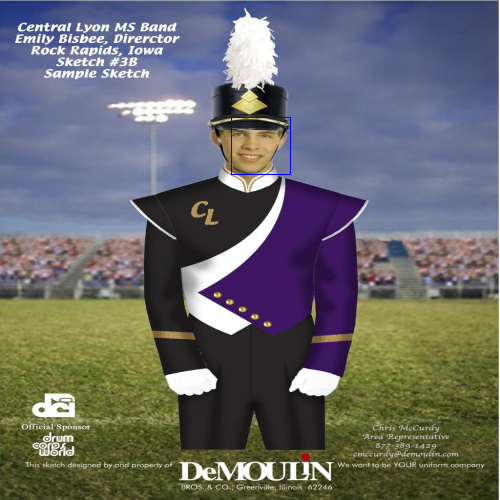

In [48]:
_, tempx, ty = GenerateBatch(0,1000)
img = tempx[0]
true_box_wh = ty[..., 2:4]
print(np.shape(true_box_wh))
i = ty[0].reshape((9,5))[4]
print(i)
Nx,Ny, Nw, Nh = ReAdjustCord(i[0]*(2/3),i[1]*(2/3), i[2], i[3],img)
# cv2.rectangle(img, (int(Nx),int(Ny)), (int(Nw)+int(Nx),int(Nh)+int(Ny)), (255,0,0)) 
# cv2_imshow(img)
# print(Nx,Ny, Nw, Nh)
tempy = model.predict(tempx)
i = tempy[0].reshape((9,5))[4]
print(sigmoid(i[4]))
Nx,Ny, Nw, Nh = sigmoid(i[0]),sigmoid(i[1]), np.exp(i[2]), np.exp(i[3])
print(Nx,Ny, Nw, Nh)
Nx,Ny, Nw, Nh = ReAdjustCord(Nx*(2/3),Ny*(2/3), Nw, Nh,img)
print(Nx,Ny, Nw, Nh)
cv2.rectangle(img, (int(Nx),int(Ny)), (int(Nw)+int(Nx),int(Nh)+int(Ny)), (255,0,0)) 
cv2_imshow(img)

In [0]:
_, tempx, ty = GenerateBatch(0,1000)
tempy = model.predict(tempx)
img = tempx[0]
print(np.shape(tempy[0]))
for idx,i in enumerate(ty[0].reshape((9,5))):
    if(float(i[4]) > 0.5):
      print("ssss",i,idx)
      Nx,Ny, Nw, Nh = sigmoid(i[0]),sigmoid(i[1]), i[2], i[3]
      print(Nx,Ny, Nw, Nh)
      Nx,Ny, Nw, Nh = ReAdjustCord(i[0],i[1], i[2], i[3],img)
      print(Nx,Ny, Nw, Nh)
      cv2.rectangle(img, (int(Nx),int(Ny)), (int(Nw)+int(Nx),int(Nh)+int(Ny)), (255,0,0)) 
      cv2_imshow(img)


In [0]:
model.save_weights("/content/drive/My Drive/Face Detection/weights.h5")

In [0]:
# predicted = model.predict(x)
# predicted = np.reshape(predicted,(1,3*3,5))
# for i in predicted[0]:
#   if(float(i[0]) > 0.5):
#     print(i)
# print(np.sum(predicted,axis = 1))
# print(np.sum(np.reshape(y,(1,3*3,5)),axis = 1))